In [1]:
# Load and combine data

# UNSW-NB15
# https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/

import os
import pandas as pd
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from joblib import dump, load
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

columns=['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 
         'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 
         'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 
         'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 
         'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 
         'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 
         'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 
         'ct_dst_src_ltm', 'attack_cat', 'Label']

df = pd.DataFrame(columns=columns)

for dirname, _, filenames in os.walk('/Users/davidhan/Documents/HKU/Year_4/Final_Year_Project/research/unsw-nb15/raw'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        print("Loading data from", path)
        df_temp = pd.read_csv(path, header=None, names=columns)
        df = df.append(df_temp, ignore_index = True)
        
df.info(null_counts=True)

Loading data from /Users/davidhan/Documents/HKU/Year_4/Final_Year_Project/research/unsw-nb15/raw/UNSW-NB15_3.csv
Loading data from /Users/davidhan/Documents/HKU/Year_4/Final_Year_Project/research/unsw-nb15/raw/UNSW-NB15_2.csv


/Users/davidhan/dev/ml_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loading data from /Users/davidhan/Documents/HKU/Year_4/Final_Year_Project/research/unsw-nb15/raw/UNSW-NB15_1.csv


/Users/davidhan/dev/ml_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,3,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loading data from /Users/davidhan/Documents/HKU/Year_4/Final_Year_Project/research/unsw-nb15/raw/UNSW-NB15_4.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   srcip             2540047 non-null  object 
 1   sport             2540047 non-null  object 
 2   dstip             2540047 non-null  object 
 3   dsport            2540047 non-null  object 
 4   proto             2540047 non-null  object 
 5   state             2540047 non-null  object 
 6   dur               2540047 non-null  float64
 7   sbytes            2540047 non-null  object 
 8   dbytes            2540047 non-null  object 
 9   sttl              2540047 non-null  object 
 10  dttl              2540047 non-null  object 
 11  sloss             2540047 non-null  object 
 12  dloss             2540047 non-null  object 
 13  service           2540047 non-null

In [2]:
df.head(20)

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.1,18247,149.171.126.4,7662,tcp,FIN,0.119596,4550,68342,31,29,7,33,-,3.004783e+05,4.514398e+06,78,80,255,255,1818376620,1818657356,58,854,0,0,87.137592,85.643619,1424231129,1424231129,1.549156,1.507190,0.000644,0.000521,0.000123,0,0,NaN,NaN,,6,2,2,5,1,1,2,NaN,0
1,59.166.0.3,54771,149.171.126.2,27709,tcp,FIN,0.650574,8928,320,31,29,4,1,ftp-data,1.019530e+05,3.283254e+03,14,6,255,255,4075447467,3777413974,638,53,0,0,4045.664812,162.187656,1424231129,1424231129,50.044153,129.990797,0.000616,0.000495,0.000121,0,0,NaN,NaN,,3,5,2,4,1,1,4,NaN,0
2,59.166.0.8,13289,149.171.126.9,5190,tcp,FIN,0.007980,2158,2464,31,29,6,6,-,2.074185e+06,2.367920e+06,24,24,255,255,1638377249,1638673555,90,103,0,0,23.013883,0.487342,1424231129,1424231129,0.347545,0.322913,0.000668,0.000544,0.000124,0,0,NaN,NaN,,3,5,1,1,1,1,3,NaN,0
3,149.171.126.18,1043,175.45.176.3,53,udp,INT,0.000005,264,0,60,0,0,0,dns,2.112000e+08,0.000000e+00,2,0,0,0,0,0,132,0,0,0,0.000000,0.000000,1424231129,1424231129,0.005000,0.000000,0.000000,0.000000,0.000000,0,0,NaN,NaN,,19,19,19,19,19,19,19,NaN,0
4,149.171.126.18,1043,175.45.176.3,53,udp,INT,0.000005,264,0,60,0,0,0,dns,2.112000e+08,0.000000e+00,2,0,0,0,0,0,132,0,0,0,0.000000,0.000000,1424231129,1424231129,0.005000,0.000000,0.000000,0.000000,0.000000,0,0,NaN,NaN,,19,19,19,19,19,19,19,NaN,0
5,59.166.0.3,10275,149.171.126.0,25,tcp,FIN,0.486578,37462,3380,31,29,18,8,smtp,6.040882e+05,5.425646e+04,52,42,255,255,1518379503,3670369209,720,80,0,0,768.061343,24.935787,1424231128,1424231129,9.533961,11.645000,0.016012,0.009132,0.006880,0,0,NaN,NaN,,3,2,3,4,2,1,2,NaN,0
6,175.45.176.0,59932,149.171.126.12,179,tcp,FIN,0.628085,534,354,254,252,2,1,-,6.126559e+03,3.948510e+03,10,8,255,255,2656904324,2464095352,53,44,0,0,4626.171078,134.850297,1424231129,1424231129,69.693889,79.491289,0.112146,0.071639,0.040507,0,1,NaN,NaN,,6,4,1,1,1,1,4,NaN,0
7,59.166.0.1,21522,149.171.126.0,19847,tcp,FIN,0.137141,4550,68342,31,29,7,33,-,2.620369e+05,3.936853e+06,78,80,255,255,4087957051,4088184097,58,854,0,0,99.378940,97.705561,1424231129,1424231129,1.776584,1.729747,0.000608,0.000487,0.000121,0,0,NaN,NaN,,6,3,3,5,1,1,2,NaN,0
8,59.166.0.7,30665,149.171.126.7,57704,tcp,FIN,0.079338,320,1896,31,29,1,2,ftp-data,2.692279e+04,1.672843e+05,6,8,255,255,3243766425,1613804297,53,237,0,0,1106.729846,27.250656,1424231129,1424231129,15.804400,11.253000,0.000743,0.000563,0.000180,0,0,NaN,NaN,,1,1,1,1,1,1,3,NaN,0
9,149.171.126.18,1043,175.45.176.3,53,udp,INT,0.000005,264,0,60,0,0,0,dns,2.112000e+08,0.000000e+00,2,0,0,0,0,0,132,0,0,0,0.000000,0.000000,1424231129,1424231129,0.005000,0.000000,0.000000,0.000000,0.000000,0,0,NaN,NaN,,19,19,19,19,19,19,19,NaN,0


In [3]:
df['attack_cat'].value_counts()

Generic             215481
Exploits             44525
 Fuzzers             19195
DoS                  16353
 Reconnaissance      12228
 Fuzzers              5051
Analysis              2677
Backdoor              1795
Reconnaissance        1759
 Shellcode            1288
Backdoors              534
Shellcode              223
Worms                  174
Name: attack_cat, dtype: int64

In [4]:
# Useless - more for snort rules

df.drop(['srcip', 'dstip', 'Stime', 'Ltime'], axis=1, inplace=True)

In [5]:
# More than 50% empty - delete columns

df.drop(['ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd'], axis=1, inplace=True)

In [6]:
# convert class into numerics

cols_to_numeric = df.select_dtypes(include=['object']).columns.drop(['proto', 'service', 'state', 'attack_cat'])
df[cols_to_numeric] = df[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

In [7]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 42 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   sport             2540039 non-null  float64
 1   dsport            2539743 non-null  float64
 2   proto             2540047 non-null  object 
 3   state             2540047 non-null  object 
 4   dur               2540047 non-null  float64
 5   sbytes            2540047 non-null  int64  
 6   dbytes            2540047 non-null  int64  
 7   sttl              2540047 non-null  int64  
 8   dttl              2540047 non-null  int64  
 9   sloss             2540047 non-null  int64  
 10  dloss             2540047 non-null  int64  
 11  service           2540047 non-null  object 
 12  Sload             2540047 non-null  float64
 13  Dload             2540047 non-null  float64
 14  Spkts             2540047 non-null  int64  
 15  Dpkts             2540047 non-null  int64  
 16  

In [8]:
df['attack_cat'].value_counts()

Generic             215481
Exploits             44525
 Fuzzers             19195
DoS                  16353
 Reconnaissance      12228
 Fuzzers              5051
Analysis              2677
Backdoor              1795
Reconnaissance        1759
 Shellcode            1288
Backdoors              534
Shellcode              223
Worms                  174
Name: attack_cat, dtype: int64

In [9]:
# Function to group attacks into a larger subset

def attack_type_to_int(row):
    label = str(row['attack_cat']).strip()
    if label == 'Generic':
        return 1
    elif label == 'Exploits': 
        return 2
    elif label == 'Fuzzers':
        return 3
    elif label == 'DoS':
        return 4
    elif label == 'Reconnaissance': 
        return 5
    elif label == 'Analysis':
        return 6
    elif label == 'Backdoor' or label == 'Backdoors': 
        return 7
    elif label == 'Shellcode':
        return 8
    elif label == 'Worms':
        return 9
    else:
        return 0

In [10]:
df['attack_type'] = df.apply(lambda row: attack_type_to_int(row), axis=1)
df = df.drop(['attack_cat', 'Label'], axis=1)
df = df.replace([np.inf], np.nan)
df.isnull().sum()

sport                 8
dsport              304
proto                 0
state                 0
dur                   0
sbytes                0
dbytes                0
sttl                  0
dttl                  0
sloss                 0
dloss                 0
service               0
Sload                 0
Dload                 0
Spkts                 0
Dpkts                 0
swin                  0
dwin                  0
stcpb                 0
dtcpb                 0
smeansz               0
dmeansz               0
trans_depth           0
res_bdy_len           0
Sjit                  0
Djit                  0
Sintpkt               0
Dintpkt               0
tcprtt                0
synack                0
ackdat                0
is_sm_ips_ports       0
ct_state_ttl          0
ct_srv_src            0
ct_srv_dst            0
ct_dst_ltm            0
ct_src_ltm            0
ct_src_dport_ltm      0
ct_dst_sport_ltm      0
ct_dst_src_ltm        0
attack_type           0
dtype: int64

In [11]:
# Drop all null columns

df = df.dropna()

In [12]:
df['attack_type'].value_counts()

0    2218456
1     215481
2      44525
3      24246
4      16353
5      13987
6       2677
7       2329
8       1511
9        174
Name: attack_type, dtype: int64

In [13]:
# Downsample benign class

df_0 = df[df.attack_type==0]

df_0 = resample(df_0, replace=False, n_samples=500000, random_state=25) 
df_rest = df[df.attack_type>0]

df = pd.concat([df_0, df_rest])

In [14]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 821283 entries, 2089206 to 2540046
Data columns (total 41 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sport             821283 non-null  float64
 1   dsport            821283 non-null  float64
 2   proto             821283 non-null  object 
 3   state             821283 non-null  object 
 4   dur               821283 non-null  float64
 5   sbytes            821283 non-null  int64  
 6   dbytes            821283 non-null  int64  
 7   sttl              821283 non-null  int64  
 8   dttl              821283 non-null  int64  
 9   sloss             821283 non-null  int64  
 10  dloss             821283 non-null  int64  
 11  service           821283 non-null  object 
 12  Sload             821283 non-null  float64
 13  Dload             821283 non-null  float64
 14  Spkts             821283 non-null  int64  
 15  Dpkts             821283 non-null  int64  
 16  swin         

In [15]:
df.describe()

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_type
count,821283.000000,821283.000000,821283.000000,8.212830e+05,8.212830e+05,821283.000000,821283.000000,821283.000000,821283.000000,8.212830e+05,8.212830e+05,821283.000000,821283.000000,821283.000000,821283.000000,8.212830e+05,8.212830e+05,821283.000000,821283.000000,821283.000000,8.212830e+05,8.212830e+05,821283.000000,821283.000000,821283.000000,821283.000000,821283.000000,821283.000000,821283.000000,821283.000000,821283.000000,821283.000000,821283.000000,821283.00000,821283.000000,821283.000000,821283.000000,821283.000000
mean,28091.754789,8041.088141,0.688129,4.798523e+03,2.682287e+04,116.545749,35.404670,4.391761,12.039974,5.507902e+07,1.706288e+06,25.977870,31.577303,118.677724,118.443303,9.974075e+08,9.994204e+08,116.499358,203.651638,0.075177,3.213996e+03,1.873289e+03,582.296468,151.397155,64.554809,0.011453,0.005815,0.005638,0.001179,0.736543,12.519441,12.329506,8.652883,9.14804,7.326918,5.655733,10.795756,0.680198
std,21617.746420,16412.577531,14.234278,9.794037e+04,1.495555e+05,106.204020,64.757246,37.447692,53.249950,1.334634e+08,3.696850e+06,91.997898,113.768574,127.194150,127.177351,1.364729e+09,1.365964e+09,154.585285,312.787461,0.449384,4.569276e+04,2.244921e+04,3239.124021,2365.102429,1186.924460,0.050187,0.027267,0.025736,0.034311,0.955873,13.201063,13.247163,10.061286,10.06940,10.505754,7.531575,13.933558,1.190721
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000
25%,3030.000000,53.000000,0.000009,1.140000e+02,0.000000e+00,31.000000,0.000000,0.000000,0.000000,2.444531e+05,0.000000e+00,2.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,57.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.008000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,2.000000,2.00000,1.000000,1.000000,1.000000,0.000000
50%,29263.000000,53.000000,0.003015,4.240000e+02,2.680000e+02,31.000000,29.000000,0.000000,0.000000,1.090184e+06,4.692534e+04,4.000000,4.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,65.000000,79.000000,0.000000,0.000000e+00,0.000000e+00,0.286857,0.271286,0.212667,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,6.000000,4.000000,5.00000,1.000000,1.000000,3.000000,0.000000
75%,47439.000000,5190.000000,0.132792,2.599000e+03,6.806000e+03,254.000000,29.000000,7.000000,7.000000,5.700000e+07,7.170191e+05,28.000000,24.000000,255.000000,255.000000,1.978163e+09,1.988718e+09,117.000000,215.000000,0.000000,0.000000e+00,1.794311e+02,47.846251,4.831822,2.855650,0.000691,0.000546,0.000138,0.000000,2.000000,20.000000,20.000000,13.000000,14.00000,12.000000,9.000000,19.000000,1.000000
max,65535.000000,65535.000000,8760.776367,1.435577e+07,1.465753e+07,255.000000,254.000000,5319.000000,5507.000000,5.988000e+09,1.287619e+08,10646.000000,11018.000000,255.000000,255.000000,4.294959e+09,4.294954e+09,1504.000000,1480.000000,172.000000,6.558056e+06,1.483831e+06,781221.118300,84371.496000,57739.240000,5.059004,3.266399,3.518718,1.000000,6.000000,67.000000,67.000000,67.000000,67.00000,67.000000,60.000000,67.000000,9.000000


In [16]:
#  Categorize ports:

df['is_well_known_port_src'] = df.apply(lambda row: 1 if row['sport'] < 1024 else 0, axis=1)
print('...')
df['is_registered_port_src'] = df.apply(lambda row: 1 if row['sport'] >= 1024 and row['sport'] < 49152 else 0, axis=1)
print('processing dest port')

df['is_well_known_port_dst'] = df.apply(lambda row: 1 if row['dsport'] < 1024 else 0, axis=1)
print('...')
df['is_registered_port_dst'] = df.apply(lambda row: 1 if row['dsport'] >= 1024 and row['dsport'] < 49152 else 0, axis=1)

df = df.drop(columns = ['sport', 'dsport'], axis=1)

...
processing dest port
...


In [17]:
# Apply scaling to all relevant columns in train and then transform test as well

scaler = StandardScaler()

cols_to_scale = df.columns.drop(['proto', 'service', 'state', 'is_sm_ips_ports', 'attack_type'])

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [18]:
print(df['proto'].value_counts())
print(df['service'].value_counts())
print(df['state'].value_counts())

udp            396325
tcp            382236
unas            16202
ospf             4331
arp              2252
sctp             1525
any               411
gre               324
rsvp              274
ipv6              272
swipe             262
sun-nd            262
mobile            262
pim               262
sep               260
3pc               137
iso-tp4           137
xtp               137
iplt              137
bbn-rcc           137
sat-expak         137
tp++              137
cpnx              137
dgp               137
skip              137
fire              137
qnx               137
egp               137
cbt               137
uti               137
trunk-2           137
xnet              137
trunk-1           137
zero              137
gmtp              137
l2tp              137
vmtp              137
ippc              137
ipv6-frag         137
ttp               137
chaos             137
iso-ip            137
larp              137
fc                137
aris              137
ax.25     

In [19]:
# Categorize protocol, service types, and state:

def value_checker(row, col_name, value):
    if row[col_name] == value:
        return 1
    else:
        return 0

In [20]:
# Pseudo dummy variables for protocols, services and states

protocols = ['tcp', 'udp', 'unas', 'arp', 'ospf', 'sctp']
services = ['dns', 'http', 'smtp', 'ftp-data', 'ftp', 'ssh', 'pop3']
states = ['INT', 'FIN', 'CON', 'REQ']

for protocol in protocols:
    col_name = 'protocol_' + protocol
    df[col_name] = df.apply(lambda row: value_checker(row, 'proto', protocol), axis=1)
    print('added', col_name)

for service in services:
    col_name = 'service_' + service
    df[col_name] = df.apply(lambda row: value_checker(row, 'service', service), axis=1)
    print('added', col_name)

for state in states:
    col_name = 'state_' + state
    df[col_name] = df.apply(lambda row: value_checker(row, 'state', state), axis=1)
    print('added', col_name)


df.drop(['proto', 'service', 'state'],axis=1, inplace=True)


added protocol_tcp
added protocol_udp
added protocol_unas
added protocol_arp
added protocol_ospf
added protocol_sctp
added service_dns
added service_http
added service_smtp
added service_ftp-data
added service_ftp
added service_ssh
added service_pop3
added state_INT
added state_FIN
added state_CON
added state_REQ


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 821283 entries, 2089206 to 2540046
Data columns (total 57 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   dur                     821283 non-null  float64
 1   sbytes                  821283 non-null  float64
 2   dbytes                  821283 non-null  float64
 3   sttl                    821283 non-null  float64
 4   dttl                    821283 non-null  float64
 5   sloss                   821283 non-null  float64
 6   dloss                   821283 non-null  float64
 7   Sload                   821283 non-null  float64
 8   Dload                   821283 non-null  float64
 9   Spkts                   821283 non-null  float64
 10  Dpkts                   821283 non-null  float64
 11  swin                    821283 non-null  float64
 12  dwin                    821283 non-null  float64
 13  stcpb                   821283 non-null  float64
 14  dtcpb        

In [22]:
# Determine columns in extended matrix with correlation >.95

df_corr = df.drop(['attack_type'],axis=1)

corr_matrix = df_corr.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop_95 = [column for column in upper.columns if any(upper[column] > 0.95)]

to_drop_95

['sloss',
 'dloss',
 'Dpkts',
 'dwin',
 'ct_srv_dst',
 'ct_src_ltm',
 'ct_src_dport_ltm',
 'ct_dst_src_ltm',
 'protocol_tcp',
 'state_FIN']

In [23]:
# Split dfs into features and labels

y = df['attack_type']
X = df.drop(['attack_type'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        train_size=0.6,
        test_size=0.4,
        random_state=25,
        stratify=y
    )

print(y_train.value_counts())
print(y_test.value_counts())

# Create train and test with correlated features removed
X_train_95 = X_train.drop(to_drop_95, axis=1)
X_test_95 = X_test.drop(to_drop_95, axis=1)

0    300000
1    129288
2     26715
3     14548
4      9812
5      8392
6      1606
7      1397
8       907
9       104
Name: attack_type, dtype: int64
0    200000
1     86193
2     17810
3      9698
4      6541
5      5595
6      1071
7       932
8       604
9        70
Name: attack_type, dtype: int64


In [24]:
# Combine minority classes for better class balance

y_train = y_train.apply(lambda x: 1 if x > 0 else 0)
y_test = y_test.apply(lambda x: 1 if x > 0 else 0)

print(y_train.value_counts())
print(y_test.value_counts())

0    300000
1    192769
Name: attack_type, dtype: int64
0    200000
1    128514
Name: attack_type, dtype: int64


In [25]:
def fit_and_score_ensemble_classifier(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    print('Accuracy:', accuracy_score(y_test, y_pred), '\n')
    print(precision_recall_fscore_support(y_test, y_pred), '\n')
    print('F1_score:', f1_score(y_test, y_pred), '\n')
    print(classification_report(y_test, y_pred), '\n')
    print(confusion_matrix(y_test, y_pred), '\n')
    print(confusion_matrix(y_test, y_pred, normalize='true'), '\n')

    
def plot_feature_importances(model, labels, color):
    values = model.feature_importances_
    index = np.arange(len(labels))
    fig = plt.figure(figsize=(16, 10))
    plt.bar(index, values, color=color)
    plt.xlabel('Feature', fontsize=10)
    plt.ylabel('Importance', fontsize=10)
    plt.xticks(index, labels, fontsize=10, rotation=90)
    plt.show()

def export_model(model, filename):
    # Dump to a retrievable file: model = load('filename.joblib') 
    dump(model, filename + '.joblib') 
    # save to Onnx file type
    initial_type = [('float_input', FloatTensorType([None, 70]))]
    onx = convert_sklearn(rf_model, initial_types=initial_type)
    with open(filename + '.onnx', 'wb') as f:
        f.write(onx.SerializeToString())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   58.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


Accuracy: 0.9920186049909593 

(array([0.99791629, 0.98304812]), array([0.988955  , 0.99678634]), array([0.99341544, 0.98986956]), array([200000, 128514])) 

F1_score: 0.9898695638735202 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    200000
           1       0.98      1.00      0.99    128514

    accuracy                           0.99    328514
   macro avg       0.99      0.99      0.99    328514
weighted avg       0.99      0.99      0.99    328514
 

[[197791   2209]
 [   413 128101]] 

[[0.988955   0.011045  ]
 [0.00321366 0.99678634]] 



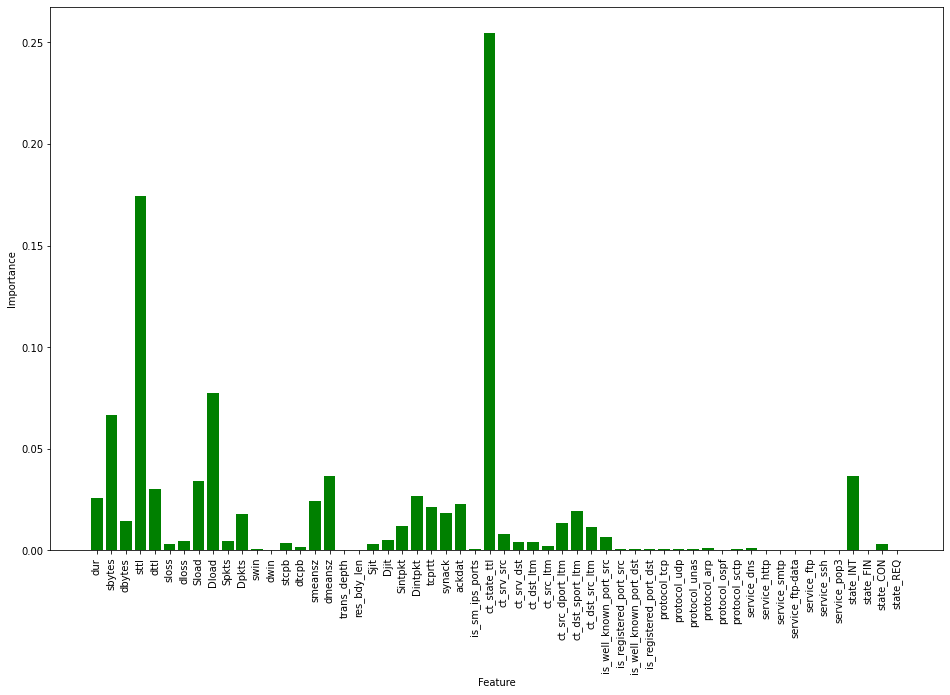

In [27]:
# Random Forest on all columns

rf_model = RandomForestClassifier(n_estimators=100, 
                            bootstrap = True,
                            max_features = 'sqrt',
                            verbose=True,
                            random_state=25)

fit_and_score_ensemble_classifier(rf_model, X_train, y_train, X_test, y_test)
plot_feature_importances(rf_model, X_train.columns, 'green')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   47.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished


Accuracy: 0.9919881648879499 

(array([0.99807199, 0.98274302]), array([0.98875   , 0.99702756]), array([0.99338913, 0.98983376]), array([200000, 128514])) 

F1_score: 0.9898337556393301 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    200000
           1       0.98      1.00      0.99    128514

    accuracy                           0.99    328514
   macro avg       0.99      0.99      0.99    328514
weighted avg       0.99      0.99      0.99    328514
 

[[197750   2250]
 [   382 128132]] 

[[0.98875    0.01125   ]
 [0.00297244 0.99702756]] 



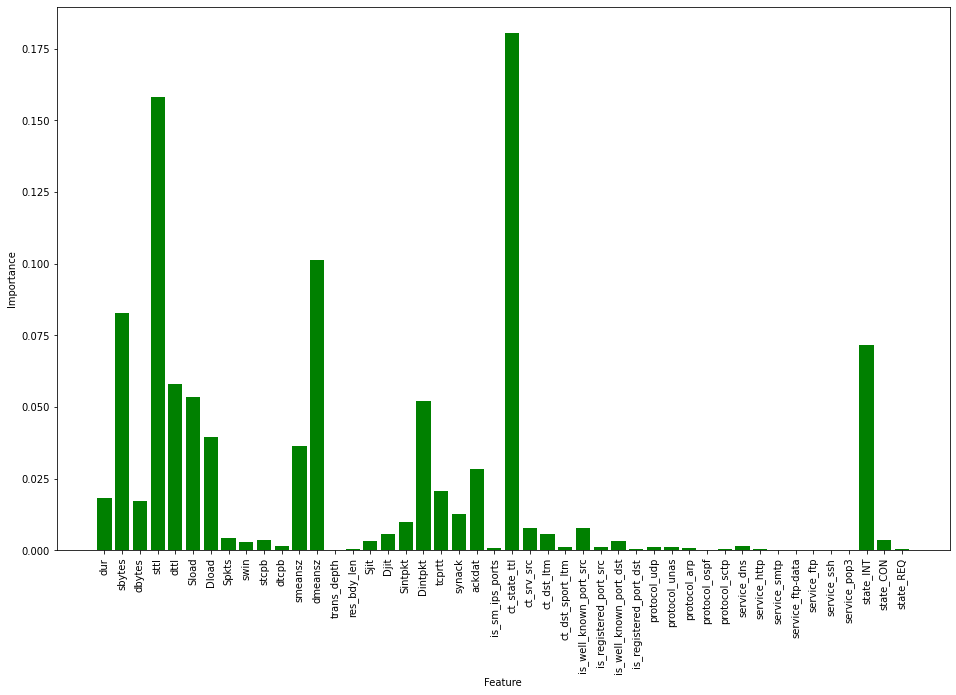

In [28]:
# Random Forest Classifier on reduced_95 

rf_model_95 = RandomForestClassifier(n_estimators=100, 
                            bootstrap = True,
                            max_features = 'sqrt',
                            verbose=True,
                            random_state=25)

fit_and_score_ensemble_classifier(rf_model_95, X_train_95, y_train, X_test_95, y_test)
plot_feature_importances(rf_model_95, X_train_95.columns, 'green')

Accuracy: 0.9920886172278807 

(array([0.99774076, 0.98348142]), array([0.989245, 0.996514]), array([0.99347472, 0.98995482]), array([200000, 128514])) 

F1_score: 0.989954817938322 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    200000
           1       0.98      1.00      0.99    128514

    accuracy                           0.99    328514
   macro avg       0.99      0.99      0.99    328514
weighted avg       0.99      0.99      0.99    328514
 

[[197849   2151]
 [   448 128066]] 

[[0.989245 0.010755]
 [0.003486 0.996514]] 



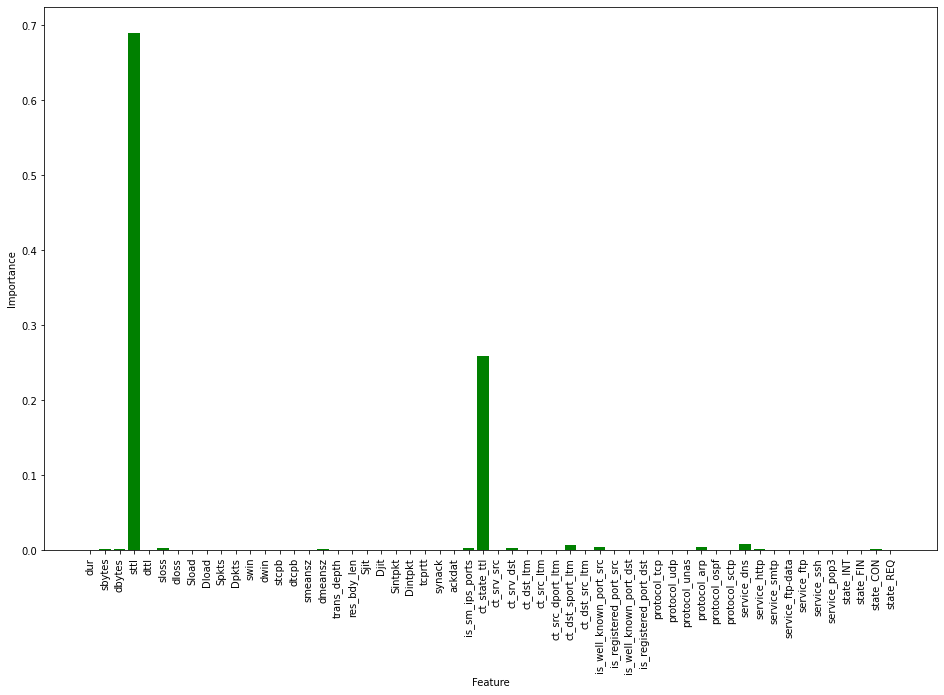

In [29]:
# XGB on all columns

xgb_model = XGBClassifier(verbosity=1, importance_type='gain', random_state=25)

fit_and_score_ensemble_classifier(xgb_model, X_train, y_train, X_test, y_test)
plot_feature_importances(xgb_model, X_train.columns, 'green')

Accuracy: 0.9918846685377183 

(array([0.99787563, 0.98277555]), array([0.988775  , 0.99672409]), array([0.99330447, 0.98970068]), array([200000, 128514])) 

F1_score: 0.9897006783799237 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    200000
           1       0.98      1.00      0.99    128514

    accuracy                           0.99    328514
   macro avg       0.99      0.99      0.99    328514
weighted avg       0.99      0.99      0.99    328514
 

[[197755   2245]
 [   421 128093]] 

[[0.988775   0.011225  ]
 [0.00327591 0.99672409]] 



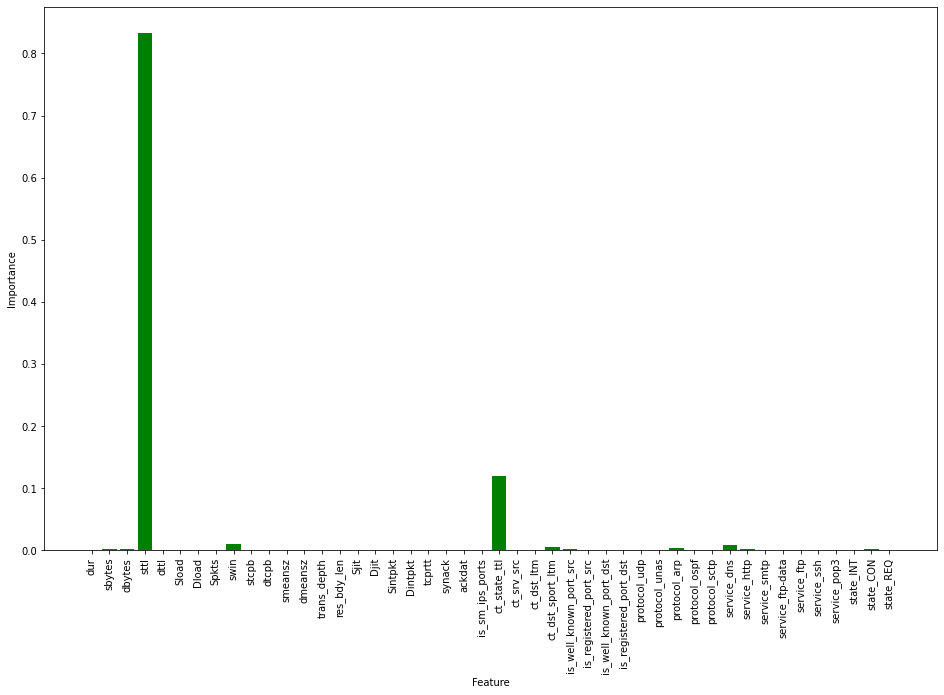

In [30]:
# XGB on 95 reduced

xgb_model_95 = XGBClassifier(verbosity=1, importance_type='gain', random_state=25)

fit_and_score_ensemble_classifier(xgb_model_95, X_train_95, y_train, X_test_95, y_test)
plot_feature_importances(xgb_model_95, X_train_95.columns, 'green')

Accuracy: 0.9918664044759128 

(array([0.99846919, 0.98185786]), array([0.988155  , 0.99764228]), array([0.99328532, 0.98968714]), array([200000, 128514])) 

F1_score: 0.9896871405744634 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    200000
           1       0.98      1.00      0.99    128514

    accuracy                           0.99    328514
   macro avg       0.99      0.99      0.99    328514
weighted avg       0.99      0.99      0.99    328514
 

[[197631   2369]
 [   303 128211]] 

[[0.988155   0.011845  ]
 [0.00235772 0.99764228]] 



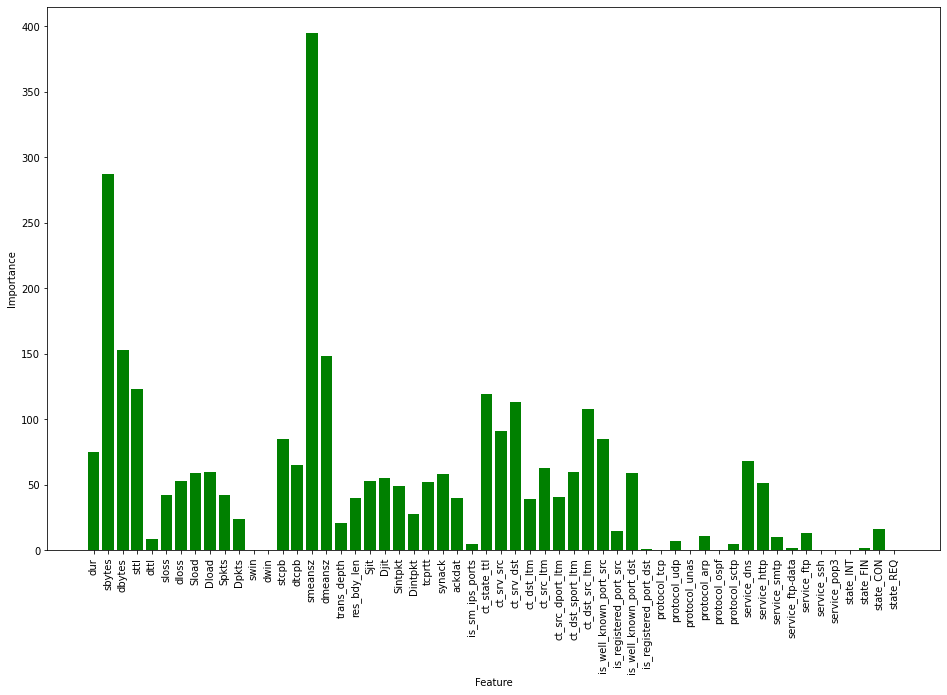

In [31]:
# LGBM on all columns

lgbm_model = LGBMClassifier(silent=False, random_state=25)

fit_and_score_ensemble_classifier(lgbm_model, X_train, y_train, X_test, y_test)
plot_feature_importances(lgbm_model, X_train.columns, 'green')

Accuracy: 0.9917416000535746 

(array([0.99881672, 0.98104146]), array([0.987605  , 0.99817919]), array([0.99317922, 0.98953613]), array([200000, 128514])) 

F1_score: 0.9895361260138928 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    200000
           1       0.98      1.00      0.99    128514

    accuracy                           0.99    328514
   macro avg       0.99      0.99      0.99    328514
weighted avg       0.99      0.99      0.99    328514
 

[[197521   2479]
 [   234 128280]] 

[[0.987605   0.012395  ]
 [0.00182081 0.99817919]] 



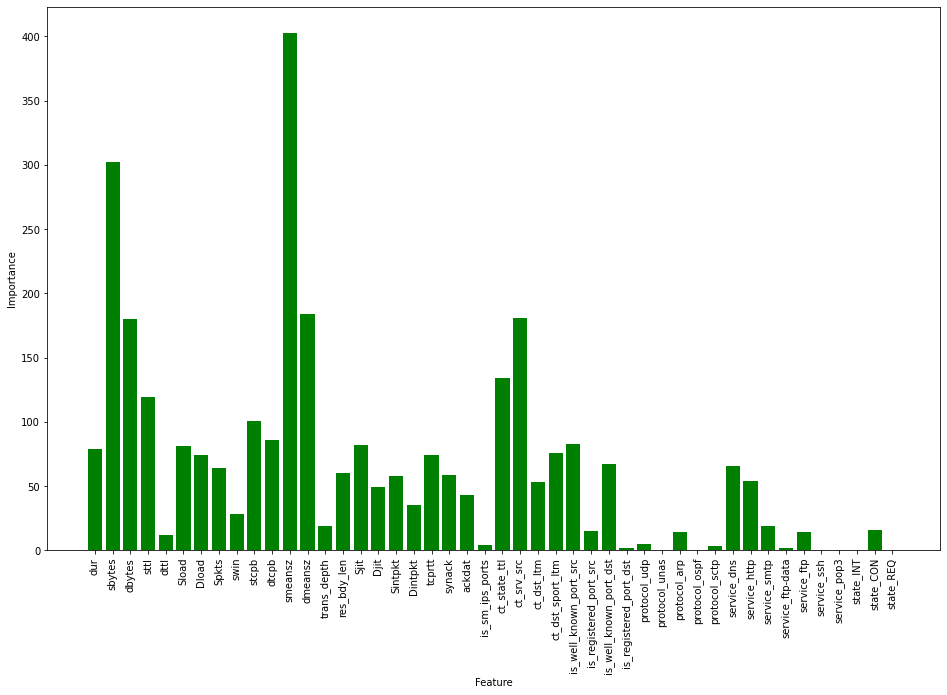

In [32]:
# LGBM on 95 reduced

lgbm_model_95 = LGBMClassifier(silent=False, random_state=1001)

fit_and_score_ensemble_classifier(lgbm_model_95, X_train_95, y_train, X_test_95, y_test)
plot_feature_importances(lgbm_model_95, X_train_95.columns, 'green')